In [1]:
import glob
import numpy as np

import matplotlib.pyplot as plt

# cognac data and tools
import cognac.insitu as iu

---
## load and select data

gps files may have to be edited manually 

In [2]:
# select campaign

#campaign = 'microco_leg2'
#campaign = 'lopstech19_leg1'
#campaign = 'cognac20'
campaign = 'sumos21'

cp = iu.campaign(campaign)

In [3]:
# data directory and filename

unit = 'recepteur0'  # no sync gps data?
unit = 'recepteur1'
unit = 'recepteur2'

flag_iridium = True

In [4]:
# path may be a list now
upath = cp[unit]['path']
if isinstance(upath, str):
    data_dir = [upath+'gps/']
else:
    data_dir = [p+'gps/' for p in upath]
gps_files = [sorted(glob.glob(_dir+'GPS_*.log')) for _dir in data_dir]
gps_files = [item for sublist in gps_files for item in sublist]

# exclude cleaned up files
gps_files = [g for g in gps_files if 'nettoye' not in g]

# only consider cleaned up files
#gps_files = [g for g in gps_files if 'nettoye' in g]

gps_all = iu.gps.read_gps_lops(gps_files, label=unit, verbose=False)

# recepteur0
# line deleted:
# $GPRMC,193221.000,A,4616.4275,N,00654.9029,W,0.46,336.99,040321,,,N,0.85,K,A*34

# manually get rid of bad data points
gps_all.d = gps_all.d[gps_all.d['lon']!=0.]

Reads /Users/aponte/Current_projects/cognac/campagnes/2021_sumos/data/deploiement0/recepteur2/gps/GPS_20210222093904.log
Reads /Users/aponte/Current_projects/cognac/campagnes/2021_sumos/data/deploiement1/recepteur2/gps/GPS_20210303134134.log


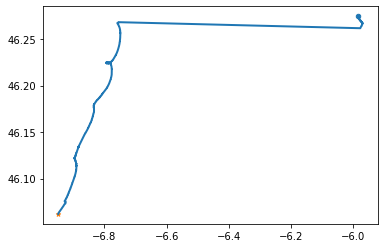

In [5]:
gps_all.plot()

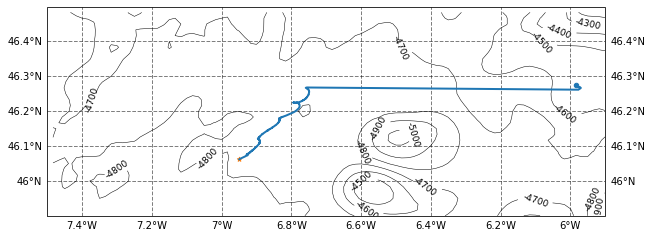

In [6]:
fac = cp.plot_map(coast='110m')
gps_all.plot(fac)

In [7]:
gps_all.plot_bk(unit=cp[unit], rule='1T')

Loading BokehJS ...

---
## trim data

Look at acoustic data in order to choose time of deployment and recovery

In [8]:
#
# clean gps data with deployment log
gps={}
for r in cp[unit]:
    gps[r.label] = gps_all.clean(r, inplace=False)

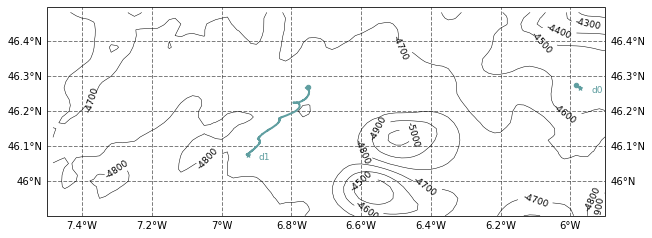

In [9]:
# plot overview map
fac = cp.plot_map(coast='110m')
for label, lgps in gps.items():
    if lgps:
        lgps.plot(fac, label=label, color=cp[unit]['color'])

In [10]:
gps

{'d0': cognac.insitu.gps.gps(recepteur2 - 12836 points),
 'd1': cognac.insitu.gps.gps(recepteur2 - 170947 points)}

In [11]:
gps['d1'].plot_bk(unit=cp[unit], rule='1T')

Loading BokehJS ...

---

## combine with iridium data

Required for sumos recepteur0

In [12]:
if flag_iridium:

    iridium = cp.load('iridium', unit=unit)[unit]

    # expand time line if necessary with correct sampling rate
    _gps = gps['d1'].reindex(cp[unit]['d1'])

    # interpolate iridium on this time line
    gps_iridium = iridium['d1'].reindex_like(_gps)

    # fill gps data with iridium data
    gps_interpolated = _gps.fillna(other=gps_iridium, interp=True) # default if linear interpolation
    #gps_interpolated = _gps.fillna(other=gps_iridium, interp={'method': 'spline', 'order': 4})
    #gps_interpolated = _gps.fillna(other=gps_iridium, interp={'method': 'polynomial', 'order': 3})
    
    # update velocity
    gps_interpolated.compute_velocity()

    # plot
    gps_interpolated.plot_bk(unit=cp[unit], rule='1T')

Loading BokehJS ...

In [13]:
if flag_iridium:
    
    for label, lgps in gps.items():
        if lgps and label in iridium:
            _gps = lgps.reindex(cp[unit][label])
            gps_iridium = iridium[label].reindex_like(_gps)
            gps_interpolated = _gps.fillna(other=gps_iridium, interp=True)
            gps[label] = gps_interpolated

---

## combine with ship data (calibrations without gps)

--- 
## store

In [14]:
for label, lgps in gps.items():
    if lgps:
        lgps.to_nc(cp.pathp+unit+'_gps_'+label+'.nc')

Data store to /Users/aponte/Current_projects/cognac/campagnes/2021_sumos/data/datap/recepteur2_gps_d0.nc
Data store to /Users/aponte/Current_projects/cognac/campagnes/2021_sumos/data/datap/recepteur2_gps_d1.nc


### read

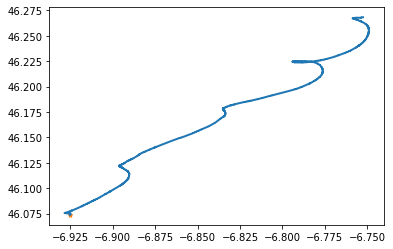

In [15]:
# reload
gps = cp.load('gps', unit=unit)[unit]
gps['d1'].plot()

---

## load all gps tracks and plot start/end positions

The goal is to adjust the yaml file positions with gps data

In [4]:
gps = cp.load('gps')
gps

{'emetteur': {'d1': cognac.insitu.gps.gps(source - 160805 points)},
 'recepteur2': {'d0': cognac.insitu.gps.gps(recepteur2 - 12836 points),
  'd1': cognac.insitu.gps.gps(recepteur2 - 172801 points)},
 'recepteur0': {'d1': cognac.insitu.gps.gps(recepteur0 - 143520 points)},
 'recepteur1': {'d1': cognac.insitu.gps.gps(recepteur1 - 165481 points)}}

In [5]:
#fmt = '%Y-%m-%d %H:%H:%S'
fmt = '%Y-%m-%d %H:%H:%S'

for uname, u in cp.items():
    print(uname)
    if uname in gps:
        for d in u:
            if d.label in gps[uname]:
                df = gps[uname][d.label].d.dropna(subset=['lon', 'lat'])
                #_gps.index.get_loc()
                istart = df.index.get_loc(d.start.time, method='nearest')
                iend = df.index.get_loc(d.end.time, method='nearest')
                print('  {}'.format(d.label))
                for e, v in dict(start=df.iloc[istart], end=df.iloc[iend]).items():
                    print('    {} (yaml): {} '.format(e, getattr(d, e).time.strftime(fmt)))                    
                    lon = iu.utils.dec2degmin(v['lon'])
                    lat = iu.utils.dec2degmin(v['lat'])
                    print('    {} (gps): {} lon/lat = {:} {:.2f} {} {:.2f}'.format(e, v.name.strftime(fmt), 
                                                                                   int(lon[0]), lon[1], lat[0], int(lat[1])
                                                                                  )
                         )
            else:
                print('{} - No gps for deployment {}'.format(uname, d.label))

emetteur
  d1
    start (yaml): 2021-03-03 14:14:00 
    start (gps): 2021-03-03 14:14:00 lon/lat = -6 52.65 46 16.00
    end (yaml): 2021-03-05 10:10:52 
    end (gps): 2021-03-05 10:10:52 lon/lat = -6 56.83 46 7.00
recepteur0
recepteur0 - No gps for deployment d1_synchro_start
  d1
    start (yaml): 2021-03-03 17:17:01 
    start (gps): 2021-03-03 17:17:01 lon/lat = -6 56.39 46 20.00
    end (yaml): 2021-03-05 09:09:00 
    end (gps): 2021-03-05 09:09:00 lon/lat = -6 56.23 46 13.00
recepteur0 - No gps for deployment d1_synchro_end
recepteur1
  d1
    start (yaml): 2021-03-03 16:16:00 
    start (gps): 2021-03-03 16:16:00 lon/lat = -6 56.41 46 11.00
    end (yaml): 2021-03-05 14:14:00 
    end (gps): 2021-03-05 14:14:00 lon/lat = -7 3.47 46 0.00
recepteur2
  d0
    start (yaml): 2021-02-22 09:09:00 
    start (gps): 2021-02-22 09:09:05 lon/lat = -5 59.06 46 16.00
    end (yaml): 2021-02-22 13:13:00 
    end (gps): 2021-02-22 13:13:00 lon/lat = -5 58.26 46 16.00
  d1
    start (yaml): 

### show all velocities

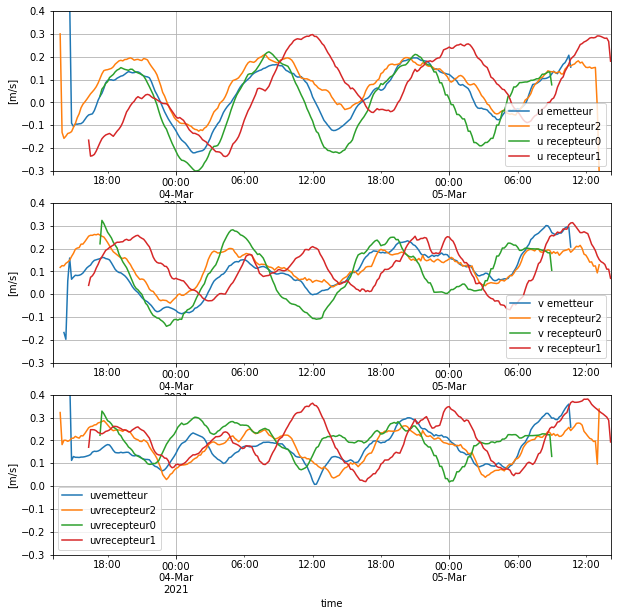

In [23]:
d = "d1"

fig, axes = plt.subplots(3, 1, figsize=(10,10))

for u, g in gps.items():
    #print(u)
    _g = g["d1"].resample("10T")
    #print(_g.d.columns)
    df = _g.compute_velocity(inplace=False)
    df["u"].plot(ax=axes[0], label="u "+u, xlabel="")
    df["v"].plot(ax=axes[1], label="v "+u, xlabel="")
    df["velocity"].plot(ax=axes[2], label="uv"+ u)

for ax in axes:
    ax.set_ylim([-.3, .4])
    ax.grid()
    ax.legend()
    ax.set_ylabel("[m/s]")